# Image Classification with PyTorch: Image Data Augmentation

[Pablo Carballeira] (http://dymas.ii.uam.es/webvpu/gti/user/186/), Escuela Politecnica Superior, Universidad Autónoma de Madrid.

Parts of this code have been adapted from then work of Kevin McGuinness (http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University, Ben Trevett (https://github.com/bentrevett), Heriot-Watt University, and Dhruvil Karani (https://github.com/DhruvilKarani)

You can find documentation about working in Colab here (https://colab.research.google.com/notebooks/intro.ipynb)

----
In this lab assignment, you will observe the effect of different common image data augmentation techniques. In the next part of the assignment (using a different notebook), you will evaluate if these techniques can improve the learning process of a network 



# Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

# Import packages


Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import decomposition
from sklearn import manifold

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets.utils import download_file_from_google_drive
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import PIL 
from PIL import Image
from torchvision.datasets import CIFAR10 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import sys 
import os 
import copy
import random
import time

import seaborn as sns 
from collections import Counter 

# sys.path.append("../models") 
# from models.resnet import ResNet

from torch.autograd import Variable
import seaborn as sns


# Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and check that *GPU* is selected under hardware accelerator.


In [3]:
# make sure to enable GPU acceleration!
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


We set the random seed so all of our experiments can be reproduced.

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Image augmentation techniques on CIFAR10: examples 

Here we will observe the effect of applying different transformations to the images of the CIFAR10 dataset an see the results in some sample images 

## Example of transformation definition

Here we show the effect of applying horizontal flipping and random cropping (two transforms that we have used in the previous lab session). Here,  `RandomHorizontalFlip` flips the image horizontally with a probability of `0.5`. `RandomCrop` is used to padd the image with 4 pixels all around the image, and then take a random crop of 32x32 pixels. Note that the way to apply `RandomCrop` is slightly different to the previous sccript (resizing + cropping)  

In [5]:
example_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

## Load the dataset applying the transformation


In [7]:
# labels of the CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# dataset download
cifar10_valid = CIFAR10(root = "./data", train= False, download = True, transform=example_transform)

100%|██████████| 170498071/170498071 [00:07<00:00, 22075628.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
print(f'train set is', ' x '.join(str(x) for x in cifar10_valid.data.shape))


train set is 10000 x 32 x 32 x 3


## Let us show some of the modified training images.


Auxiliary functions to show a set of transformed images and their labels

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [10]:
def plot_images(images, labels, classes):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (8, 8))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Let's show a set of images. By running the following cell several times, you can check that several exexutions of the code will produce different transformations. Transformations are applied with a given probbilty each time the CIFAR10 class is called.

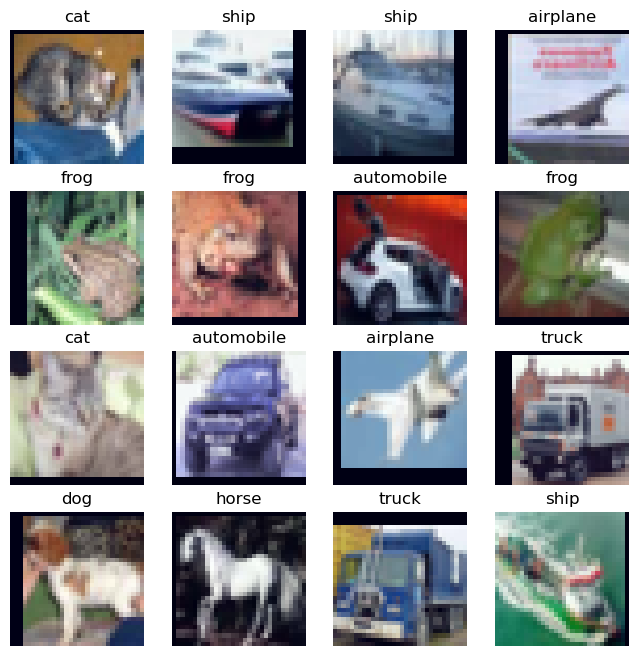

In [11]:
N_IMAGES = 16

images, labels = zip(*[(image, label) for image, label in 
                           [cifar10_valid[i] for i in range(N_IMAGES)]])
classes = cifar10_valid.classes
plot_images(images, labels, classes)

## Rotation


In [15]:
# define a transformation to rotate the images a random angle, betwen -30 and 30 degrees.
# Use the bilinear interpolation for image resampling
valid_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

cifar10_valid = CIFAR10(root = "./data", train=False, download = True, transform=valid_transform)

Files already downloaded and verified


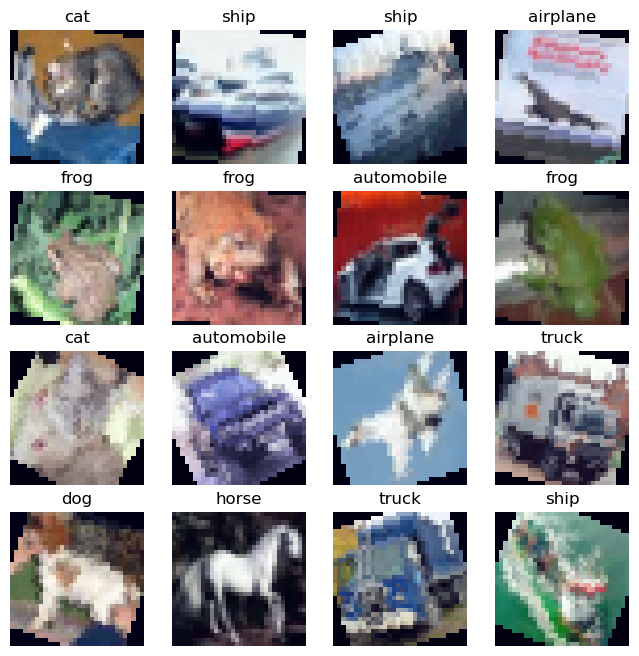

In [16]:
N_IMAGES = 16

images, labels = zip(*[(image, label) for image, label in 
                           [cifar10_valid[i] for i in range(N_IMAGES)]])
classes = cifar10_valid.classes
plot_images(images, labels, classes)

## Random Erasing

In [28]:
# define the transformation to erase a random square patch of all images,
# and replace it with a mid-gray patch. The erased patch must be between 2% and 25% of the image size   
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    transforms.RandomErasing(p=1, scale=(0.02, 0.25)),
])

cifar10_valid = CIFAR10(root = "./data", train=False, download = True, transform=valid_transform)

Files already downloaded and verified


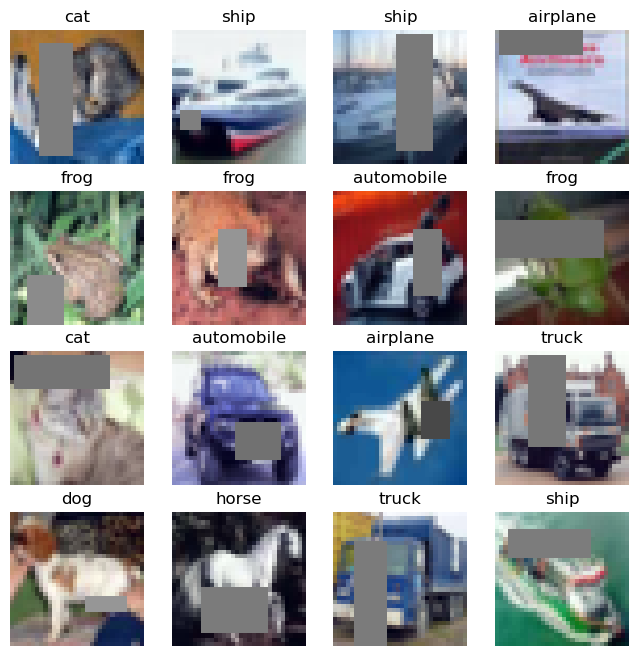

In [29]:
N_IMAGES = 16

images, labels = zip(*[(image, label) for image, label in 
                           [cifar10_valid[i] for i in range(N_IMAGES)]])
classes = cifar10_valid.classes
plot_images(images, labels, classes)

## Color Jitter

In [31]:
# define the transformation to apply color jitter to all images. The parameters of the transformation are: 
# brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2    
valid_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

cifar10_valid = CIFAR10(root = "./data", train=False, download = True, transform=valid_transform)

Files already downloaded and verified


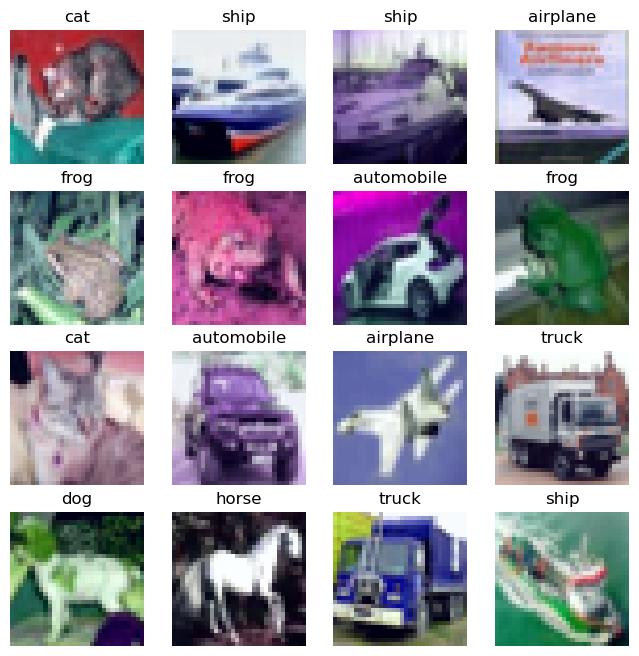

In [32]:
N_IMAGES = 16

images, labels = zip(*[(image, label) for image, label in 
                           [cifar10_valid[i] for i in range(N_IMAGES)]])
classes = cifar10_valid.classes
plot_images(images, labels, classes)

## Five Crops at test time

We will also try an image transformation that is used at inference time.  Instead of obtaining class scores from a single test image, class scores can be averaged over the scores obtained drom slightly different inputs (image crops)


In [48]:

# Resize the input image to 40x40 pixels (using bilinear interpolation) and use the FiveCrop function to extract 
# five crops from the resized image. Warning: Each input image generates 5 images. Therefore you have to change the way to convert inmages to Tensors, and the normalization
# Check the FiveCrop help to learn how to do it
test_crops_transform = transforms.Compose([
    transforms.Resize(40), # Uses by default bilinear interpolation
    transforms.FiveCrop(40),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])


In [49]:
# test loader
cifar10_test = CIFAR10(root = "./data", train=False, download = True, transform = test_crops_transform)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=5, shuffle=True)

Files already downloaded and verified


In [50]:
def plot_only_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (8, 8))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.axis('off')

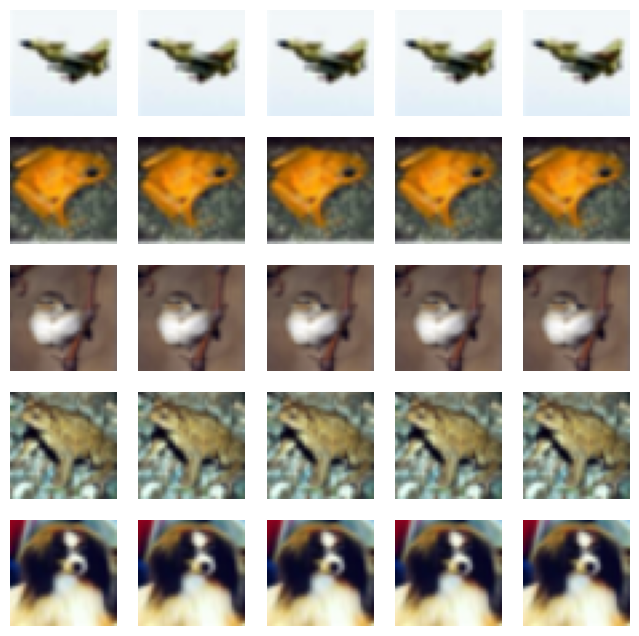

In [51]:
# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter) # dataiter.next() does not work... https://discuss.pytorch.org/t/dataloader-has-no-attribute-dataset/146623/7
bs, ncrops, c, h, w = images.size()

images = images.view(-1, c, h, w)

# show images
plot_only_images(images)